In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [3]:
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from mxresnet import *
from ranger import Ranger

seed = 12345

Mish activation loaded...
Mish activation loaded...


In [5]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

In [6]:
bs = 32
sz = 224

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [9]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)

In [13]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()


In [14]:
learn.load('best_a40A-50');

set state called


# look at ten random sources

In [78]:
# always pick the same 10 numbers
random_state = np.random.RandomState(seed=123)

source_idxs = random_state.randint(0, len(data.valid_ds), size=10)
source_idxs

array([510, 365, 382, 322,  98, 742,  17, 595, 106, 123])

In [79]:
for idx in source_idxs:
    
    im = data.valid_ds.x[idx]
#     fn = data.valid_ds.items[idx]
    agcnr = data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int)
    y = data.valid_ds.y[idx]
    p = learn.predict(data.valid_ds.x[idx])[0].data[0]
    
    print(idx, agcnr, y, p)

510 205070 0.469174 0.7045499
365 226018 0.404326 0.3793664
382 4568 0.290648 0.11313328
322 226075 0.315775 0.30697155
98 210746 -0.379929 -0.11437163
742 732564 0.587251 0.80241656
17 220910 -0.07004 -0.09989855
595 722721 0.606222 0.63164306
106 9340 0.063114 0.03433028
123 184204 0.385528 0.40807238


## Example source: idx=106, AGC 9340

9340

0.063114 0.03433028


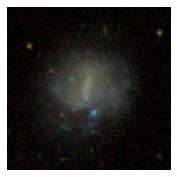

In [74]:
idx = 106

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

display(show_image(data.valid_ds.x[idx]));
print(y, p)


## Example source: idx=17, AGC 220910

220910

-0.07004 -0.09989855


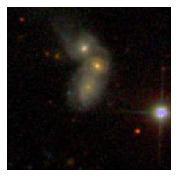

In [81]:
idx = 17

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

display(show_image(data.valid_ds.x[idx]));
print(y, p)


## Example source: idx=322, AGC 226075

226075

0.315775 0.30697155


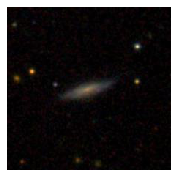

In [82]:
idx = 322

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

display(show_image(data.valid_ds.x[idx]));
print(y, p)


# Transformation: adding random red stars

In [162]:
s = 224
x0, y0 = 56, 56

x, y = np.meshgrid(np.arange(224), np.arange(224))
sigma, mu = 5.0, 0.0
ps = np.exp(-((x-x0)**2 + (y-y0)**2)**2 /(2.0 * sigma**2))

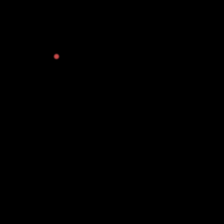

In [163]:
Image(as_tensor(np.moveaxis(ps[:, :, np.newaxis] * np.array([0.8, 0.3, 0.3]), -1, 0)))

In [196]:
def add_ps(X, pos=[56, 56], r=5, amps=np.array([0.8, 0.3, 0.3])):
    """Inputs and ouputs an image with random 2d Gaussian point source included at `loc`
    
    """
    x0, y0 = pos
    
    x, y = np.meshgrid(np.arange(224), np.arange(224))
    ps = np.exp(-((x-x0)**2 + (y-y0)**2)**2 /(2.0 * r**2))
    
    # `amps` controls the color variation
    ps = ps[:, :, np.newaxis] * amps
    
    return Image(as_tensor(np.clip(np.moveaxis(image2np(X.data) + ps, -1, 0), 0, 1)).float())

## Test function

226075

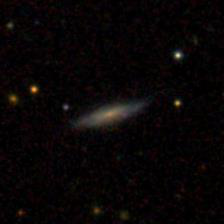

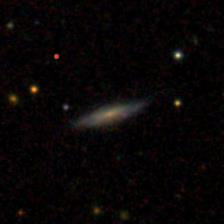

0.315775 0.30697155 0.30697313


In [197]:
idx = 322

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im2 = add_ps(im, [56, 56], r=5)
p2 = learn.predict(im2)[0].data[0]

display(im)
display(im2)

print(y, p, p2)


## Add 6 random point sources (all same color)

In [217]:
random_state = np.random.RandomState(seed=123)
rand_positions = random_state.randint(1, 223, size=2*6).reshape((6, 2))


In [219]:
random_state = np.random.RandomState(seed=42)
rand_positions = random_state.randint(1, 223, size=2*6).reshape((6, 2))


226075

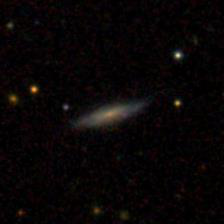

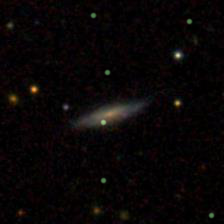

0.315775 0.30697155 0.30428568


In [230]:
idx = 322

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im_ = im
for pos in rand_positions:
    im_ = add_ps(im_, pos, r=5, amps=np.array([0.3, 0.5, 0.3]))
    
p2 = learn.predict(im_)[0].data[0]

display(im)
display(im_)

print(y, p, p2)


226075

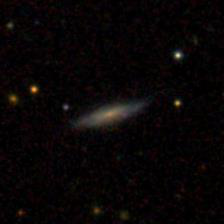

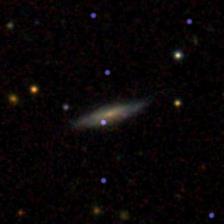

0.315775 0.30697155 0.312191


In [222]:
idx = 322

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im_ = im
for pos in rand_positions:
    im_ = add_ps(im_, pos, r=5, amps=np.array([0.3, 0.3, 0.7]))
    
p2 = learn.predict(im_)[0].data[0]

display(im)
display(im_)

print(y, p, p2)


226075

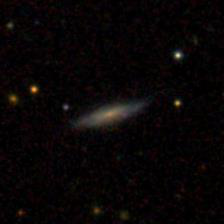

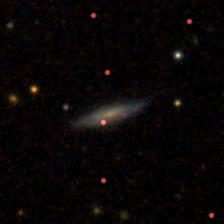

0.315775 0.30697155 0.30294782


In [223]:
idx = 322

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im_ = im
for pos in rand_positions:
    im_ = add_ps(im_, pos, r=5, amps=np.array([0.8, 0.3, 0.3]))
    
p2 = learn.predict(im_)[0].data[0]

display(im)
display(im_)

print(y, p, p2)


# Return to source idx=106

9340

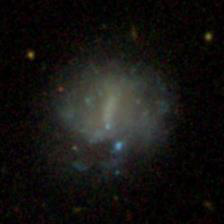

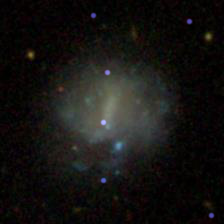

0.063114 0.03433028 0.046438694


In [225]:
idx = 106

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im_ = im
for pos in rand_positions:
    im_ = add_ps(im_, pos, r=5, amps=np.array([0.3, 0.3, 0.7]))
    
p2 = learn.predict(im_)[0].data[0]

display(im)
display(im_)

print(y, p, p2)


9340

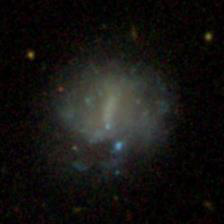

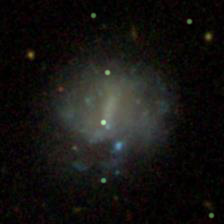

0.063114 0.03433028 0.10866073


In [234]:
idx = 106

display(data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int))
y = data.valid_ds.y[idx]

# unperturbed preds
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]

# perturbed preds
im_ = im
for pos in rand_positions:
    im_ = add_ps(im_, pos, r=5, amps=np.array([0.3, 0.5, 0.3]))
    
p2 = learn.predict(im_)[0].data[0]

display(im)
display(im_)

print(y, p, p2)


# Run 100 simulations with blue, green, and red point sources (6 each)

In [231]:
import tqdm

# idx=106

In [324]:
idx = 106
agcnr = data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int)

    
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]
y = data.valid_ds.y[idx].data

print(p, y)

0.03433028 0.063114


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


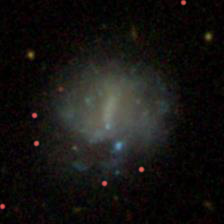

In [325]:
N = 100
num_ps = 6

preds_r = np.zeros((N,))

# add red point source
add_red_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.8, 0.3, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_red_ps(im_)
        
    preds_r[i] = learn.predict(im_)[0].data[0]

# show example
im_ 

100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


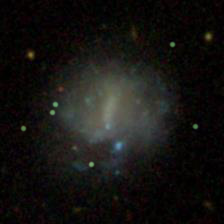

In [326]:
N = 100
num_ps = 6

preds_g = np.zeros((N,))

# add red point source
add_green_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.5, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_green_ps(im_)
        
    preds_g[i] = learn.predict(im_)[0].data[0]
    
im_    

100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


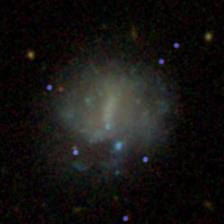

In [327]:
N = 100
num_ps = 6

preds_b = np.zeros((N,))

# add red point source
add_blue_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.3, 0.7]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_blue_ps(im_)
        
    preds_b[i] = learn.predict(im_)[0].data[0]
    
im_ 

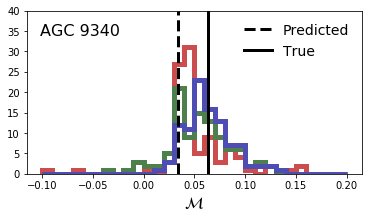

In [328]:
plt.figure(figsize=(6, 3))

plt.hist(preds_r, histtype='step', range=(-0.1, 0.2), bins=30, lw=5, color=np.array([0.8, 0.3, 0.3]));
plt.hist(preds_g, histtype='step', range=(-0.1, 0.2), bins=30, lw=5, color=np.array([0.3, 0.5, 0.3]));
plt.hist(preds_b, histtype='step', range=(-0.1, 0.2), bins=30, lw=5, color=np.array([0.3, 0.3, 0.7]));


plt.axvline(x=p, c='k', lw=3, ls='--', label='Predicted')
plt.axvline(x=y, c='k', lw=3, ls='-', label='True')

plt.xlabel(r'$\mathcal{M}$', fontsize=16)

plt.ylim(0, 40)
lg = plt.legend(fontsize=14, frameon=False)

plt.text(0.04, 0.85, f'AGC {agcnr}', fontsize=16, transform=plt.gca().transAxes)

plt.savefig(f'{PATH}/results/figures-updated/perturbed-results_AGC-{agcnr}.pdf')

# Example: idx=322, AGC 226075

In [329]:
idx = 322
agcnr = data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int)

    
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]
y = data.valid_ds.y[idx].data

print(p, y)

0.30697155 0.315775


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


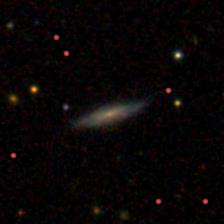

In [330]:
N = 100
num_ps = 6

preds_r = np.zeros((N,))

# add red point source
add_red_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.8, 0.3, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_red_ps(im_)
        
    preds_r[i] = learn.predict(im_)[0].data[0]
    
im_           

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


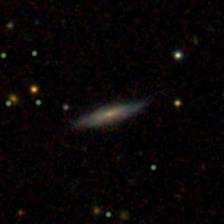

In [331]:
N = 100
num_ps = 6

preds_g = np.zeros((N,))

# add red point source
add_green_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.5, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_green_ps(im_)
        
    preds_g[i] = learn.predict(im_)[0].data[0]
    
im_   

100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


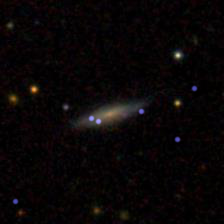

In [332]:
N = 100
num_ps = 6

preds_b = np.zeros((N,))

# add red point source
add_blue_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.3, 0.7]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_blue_ps(im_)
        
    preds_b[i] = learn.predict(im_)[0].data[0]
    
im_ 

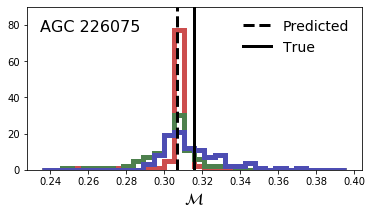

In [333]:
plt.figure(figsize=(6, 3))

plt.hist(preds_r, histtype='step', range=(y-0.08, y+0.08), bins=30, lw=5, color=np.array([0.8, 0.3, 0.3]));
plt.hist(preds_g, histtype='step', range=(y-0.08, y+0.08), bins=30, lw=5, color=np.array([0.3, 0.5, 0.3]));
plt.hist(preds_b, histtype='step', range=(y-0.08, y+0.08), bins=30, lw=5, color=np.array([0.3, 0.3, 0.7]));


plt.axvline(x=p, c='k', lw=3, ls='--', label='Predicted')
plt.axvline(x=y, c='k', lw=3, ls='-', label='True')

plt.xlabel(r'$\mathcal{M}$', fontsize=16)

plt.ylim(0, 90)
lg = plt.legend(fontsize=14, frameon=False)

plt.text(0.04, 0.85, f'AGC {agcnr}', fontsize=16, transform=plt.gca().transAxes)

plt.savefig(f'{PATH}/results/figures-updated/perturbed-results_AGC-{agcnr}.pdf')

# Try the messy merger: idx=17, AGC 220910¶

In [337]:
idx = 17
agcnr = data.valid_ds.inner_df.iloc[idx].AGCNr.astype(int)

    
im = data.valid_ds.x[idx]
p = learn.predict(data.valid_ds.x[idx])[0].data[0]
y = data.valid_ds.y[idx].data

print(p, y)

-0.09989855 -0.07004


100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


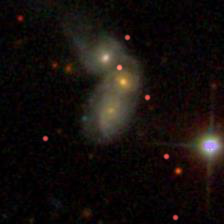

In [338]:
N = 100
num_ps = 6

preds_r = np.zeros((N,))

# add red point source
add_red_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.8, 0.3, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_red_ps(im_)
        
    preds_r[i] = learn.predict(im_)[0].data[0]
    
im_         

100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


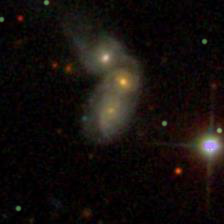

In [339]:
N = 100
num_ps = 6

preds_g = np.zeros((N,))

# add red point source
add_green_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.5, 0.3]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_green_ps(im_)
        
    preds_g[i] = learn.predict(im_)[0].data[0]
    
im_ 

100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


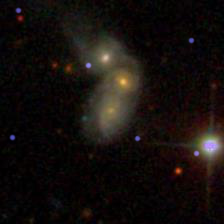

In [340]:
N = 100
num_ps = 6

preds_b = np.zeros((N,))

# add red point source
add_blue_ps = lambda x: add_ps(im_, pos, r=5, amps=np.array([0.3, 0.3, 0.7]))

for i in tqdm.tqdm(range(N)):
    rand_positions = np.random.randint(0, 224, size=2*num_ps).reshape((num_ps, 2))
    
    im_ = im 
    for pos in rand_positions:
        im_ = add_blue_ps(im_)
        
    preds_b[i] = learn.predict(im_)[0].data[0]
    
im_ 

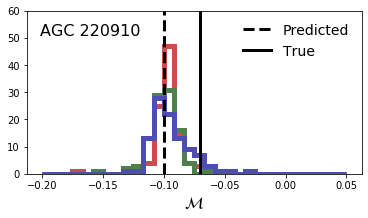

In [341]:
plt.figure(figsize=(6, 3))

plt.hist(preds_r, histtype='step', range=(-0.2, 0.05), bins=30, lw=5, color=np.array([0.8, 0.3, 0.3]));
plt.hist(preds_g, histtype='step', range=(-0.2, 0.05), bins=30, lw=5, color=np.array([0.3, 0.5, 0.3]));
plt.hist(preds_b, histtype='step', range=(-0.2, 0.05), bins=30, lw=5, color=np.array([0.3, 0.3, 0.7]));


plt.axvline(x=p, c='k', lw=3, ls='--', label='Predicted')
plt.axvline(x=y, c='k', lw=3, ls='-', label='True')

plt.xlabel(r'$\mathcal{M}$', fontsize=16)

plt.ylim(0, 60)
lg = plt.legend(fontsize=14, frameon=False)

plt.text(0.04, 0.85, f'AGC {agcnr}', fontsize=16, transform=plt.gca().transAxes)

plt.savefig(f'{PATH}/results/figures-updated/perturbed-results_AGC-{agcnr}.pdf')